In [1]:
import fdtd
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
# import torch
from tqdm import tqdm_notebook as tqdm
import tifffile as tf
import os
import time

fdtd.set_backend("numpy")
#fdtd.set_backend("torch.cuda")

In [7]:
from fdtd.backend import backend as bd

def asphere(s, c, k=-0.75, As=[], extra=0):
    # units in mm
    z = c * s**2 / (1 + np.sqrt(1 - (1 + k) * c**2 * s**2))
    for n, A in enumerate(As):
        z += A*s**(n*2 + 2)
    return z

def efield(grid, z=0):
    return bd.sum(grid.E, -1)[:, :, z]

def onhost(arr):
    if hasattr(arr, 'cpu'):
        return np.array(arr.cpu())
    return arr

def run(grid, total, dt, progress_bar=True):
    if isinstance(total_time, float):
        total_time /= grid.time_step
    time = range(0, int(total_time), 1)
    if progress_bar:
        time = tqdm(time)
    for _ in time:
        grid.step()
        

def crop_center(img,cropx,cropy, cropz=None):
    if img.ndim == 2:
        y,x = img.shape
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)
        return img[starty:starty+cropy,startx:startx+cropx]
    elif img.ndim == 3:
        z,y,x = img.shape
        if not cropz:
            cropz = z
        startz = z//2-(cropz//2)
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)
        return img[startz:startz+cropz,starty:starty+cropy,startx:startx+cropx]


c = 299792458

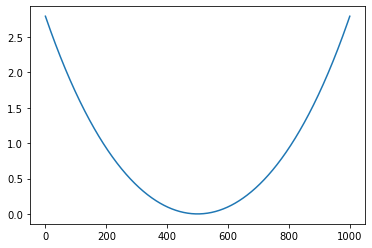

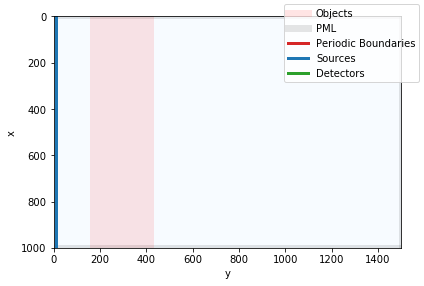


1.445356845855713


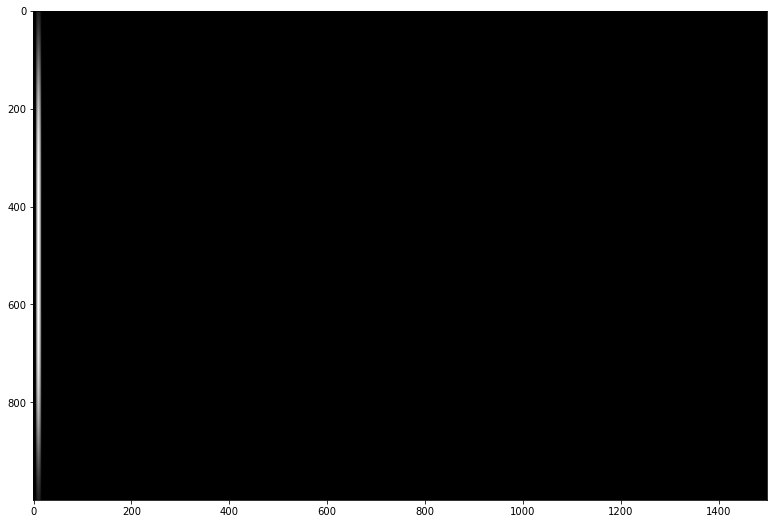

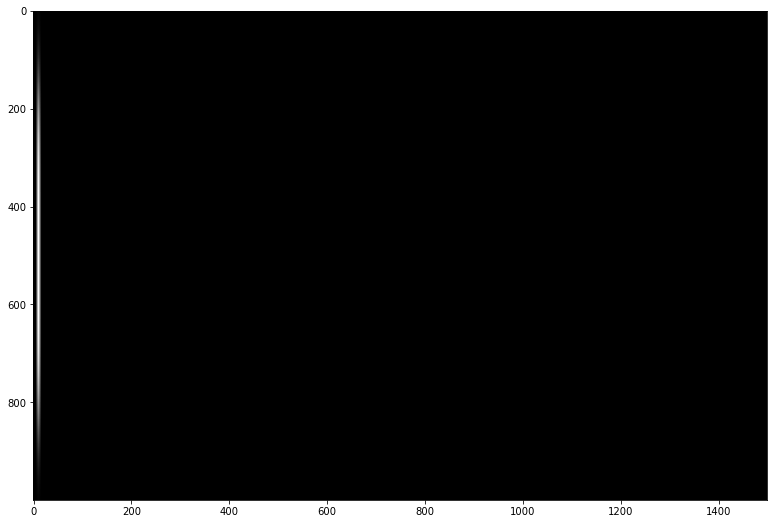

In [10]:
# make Grid
WRITE = False
PIXEL = 20e-9  # 100nm
WIDTH = 20e-6  # 25 microns
HEIGHT = 30e-6  # 25 microns

WAVE = 600e-9
lens_scale = 1
extra=0 # extra thickness at base
refractive_index = 1.68

total = 1000
dt = 10

grid = fdtd.Grid(
    shape = (int(WIDTH//PIXEL), int(HEIGHT//PIXEL), 1), # 30µm x 30µm x 1 (grid_spacing) --> 2D FDTD
    grid_spacing = PIXEL, # 100nm "pixel" size
    permittivity = 1,
)


period = WAVE/c

grid[:, 11, 0] = fdtd.LineSource(period=period, name="source")
# grid[50:250, 250, 0] = fdtd.LineDetector(name="detector")
# x boundaries
# grid[0, :, :] = fdtd.PeriodicBoundary(name="xbounds")
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")

# y boundaries
# grid[:, 0, :] = fdtd.PeriodicBoundary(name="ybounds")
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

# grid[:grid.shape[0]//5, 25:35, 0] = fdtd.Object(permittivity=10000, name="barrier_top")
# grid[4*grid.shape[0]//5:, 25:35, 0] = fdtd.Object(permittivity=10000, name="barrier_bottom")


imheight = int(grid.shape[0] * lens_scale)
semidiam=5 # semi-diameter
pixelsize = (semidiam*2) / (imheight-1) # mm
curve=1.982161E-01 # 1/radius of lens curvature
k=-1.055033E+00 
As = [0, 5.096600E-04, 2.254951E-06, 8.064402E-09, -9.079062E-10]
s = np.linspace(-semidiam,semidiam, imheight)
surface = asphere(s, curve, k, As,extra)
surface /= pixelsize
ny = int(surface.max()+ (extra/pixelsize))
lens,yy = np.mgrid[:len(surface), :ny]
lens = np.zeros_like(yy)
lens[yy>surface[:, np.newaxis]] = 1
m = grid.shape[0]//2
lens = lens[imheight//2 - m : imheight//2 + m]
plt.imshow(lens)

permittivity = bd.ones((*lens.shape,1))
permittivity += bd.array(lens[:,:,None])*(refractive_index**2 - 1)
lens_start = int(lens.shape[0]/6.4)
grid[:,lens_start:lens_start+lens.shape[1], 0] = fdtd.Object(permittivity=permittivity, name="object")
grid.visualize(z=0)

a = time.time()
grid.reset()
passed = 0

if WRITE:
    outdir = f'lensfigs/{round(wavelength*1e9)}nm_{"x".join([str(i) for i in grid.shape[:2]])}/'
    idir = os.path.join(outdir, 'intensity')
    edir = os.path.join(outdir, 'efield')
    for d in (idir, edir):
        os.makedirs(d, exist_ok=True)

    
for t in tqdm(np.arange(passed,total,dt)):
    grid.run(total_time=dt, progress_bar=False)
    if WRITE:
        img = onhost(efield(grid, z=0))
        tf.imsave(os.path.join(edir, f'e_{passed:04}.tif'), img.astype('single'), imagej=True)
        tf.imsave(os.path.join(idir, f'i_{passed:04}.tif'), (img**2).astype('single'), imagej=True)
    passed += dt

img = onhost(efield(grid, z=0))
fig, ax = plt.subplots(figsize=(14,9))
ax.imshow(img, cmap='gray')
fig, ax = plt.subplots(figsize=(14,9))
ax.imshow(img**2, cmap='gray')
print(time.time() - a)

(1000, 258)


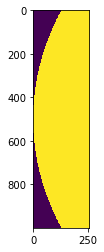

In [30]:
lens_scale = 2
extra=-1.5 # extra thickness at base
imheight = grid.shape[0] * lens_scale
semidiam=5 # semi-diameter
pixelsize = (semidiam*2) / (imheight-1) # mm
c=1.982161E-01 # 1/radius of lens curvature
k=-1.055033E+00 
As = [0, 5.096600E-04, 2.254951E-06, 8.064402E-09, -9.079062E-10]
s = np.linspace(-semidiam,semidiam, imheight)
surface = asphere(s, c, k, As,extra)
surface /= pixelsize
ny = int(surface.max()+ (extra/pixelsize))
lens,yy = np.mgrid[:len(surface), :ny]
lens = np.zeros_like(yy)
lens[yy>surface[:, np.newaxis]] = 1
m = grid.shape[0]//2
lens = lens[imheight//2 - m : imheight//2 + m]
plt.imshow(lens)
print(lens.shape)

In [82]:
from glob import glob
from matplotlib.colors import PowerNorm

def save_frame(arg):
    try:
        t, folder = arg
        seq = tf.TiffSequence(sorted(glob(os.path.join(folder, '*.tif'))))
        im = seq.asarray(t).T

        def intensity(t, binsize = 15):
            if t < binsize:
                ims = np.stack([seq.asarray(k) for k in range(t+1)])
            else:
                ims = np.stack([seq.asarray(k) for k in range(t-binsize, t+1)])
            return (ims**2).mean(0).T

        ratio = np.divide(*im.shape)
        fig = plt.figure(frameon=False, figsize=(2/ratio,1), dpi=im.shape[0])
        ax1 = fig.add_axes([0, 0, .5, 1], label='ax1')
        ax2 = fig.add_axes([.5, 0, .5, 1], label='ax2')
        ax1.axis('off')
        ax2.axis('off')
        im1 = ax1.imshow(im, cmap='bwr', vmin=-0.003, vmax=0.003)
        im2 = ax2.imshow(intensity(t), cmap='cubehelix', norm=PowerNorm(gamma=0.8), vmax=0.95e-5)

        outdir = folder.replace('efield', 'gifs')
        fig.savefig(os.path.join(outdir, f"{t:04}.png"))
        plt.close()
    except Exception as e:
        print(e)

In [84]:
from multiprocessing import Pool

fold = '/home/tjl10/python/notebooks/lensfigs/900nm_1000x1500/efield/'
outdir = fold.replace('efield', 'gifs')
os.makedirs(outdir, exist_ok=True)

# save_frame((600, fold))

with Pool(24) as p:
    p.map(save_frame,  zip(range(1000), [fold] * 1000))
    

/opt/miniconda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/miniconda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/miniconda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see

In [63]:
seq = tf.TiffSequence(sorted(glob(os.path.join(fold, '*.tif'))))

In [18]:
seq.asarray(0).shape

(1000, 1500)